In [1]:
# Basics
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Load Data

In [2]:
flag_file = 0 #1: Grocery and Food; 0: Video Games
columns_name = ['user_id','prod_id','rating', 'timestamp']
if flag_file:
    df = pd.read_csv('data/ratings_Grocery_and_Gourmet_Food.csv', header=None, names=columns_name)
else:
    df = pd.read_csv('data/ratings_Video_Games.csv', header=None, names=columns_name)

In [3]:
# See First 5 Records
df.head()

,user_id,prod_id,rating,timestamp
0,AB9S9279OZ3QO,0078764343,5.0,1373155200
1,A24SSUT5CSW8BH,0078764343,5.0,1377302400
2,AK3V0HEBJMQ7J,0078764343,4.0,1372896000
3,A10BECPH7W8HM7,043933702X,5.0,1404950400
4,A2PRV9OULX1TWP,043933702X,5.0,1386115200


# Exploratory Data Analysis

In [4]:
print("Geral Information")
print(f"Total number of ratings: {df.shape[0]}")
print(f"Total number of users: {len(np.unique(df.user_id))}")
print(f"Total number of products: {len(np.unique(df.prod_id))}")

Geral Information
Total number of ratings: 1324753
Total number of users: 826767
Total number of products: 50210


In [5]:
# Some important information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324753 entries, 0 to 1324752
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1324753 non-null  object 
 1   prod_id    1324753 non-null  object 
 2   rating     1324753 non-null  float64
 3   timestamp  1324753 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 40.4+ MB


In [6]:
# Summary
df.describe()

,rating,timestamp
count,1.324753e+06,1.324753e+06
mean,3.978754e+00,1.299234e+09
std,1.378987e+00,1.092552e+08
min,1.000000e+00,8.789472e+08
25%,3.000000e+00,1.252022e+09
50%,5.000000e+00,1.346544e+09
75%,5.000000e+00,1.379894e+09
max,5.000000e+00,1.406074e+09


/home/salomao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/salomao/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


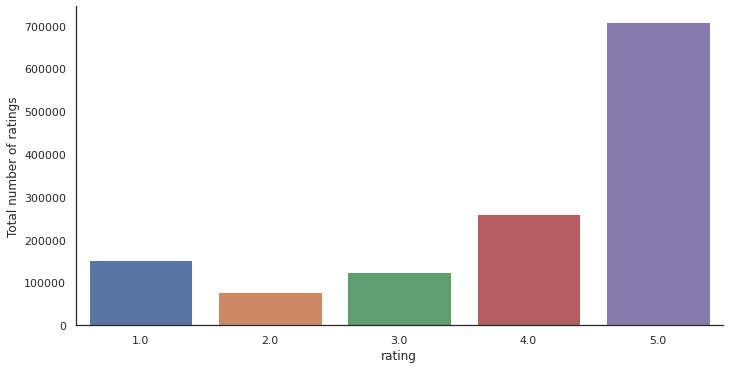

In [7]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot('rating', data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [8]:
# Rate frequency by user
user_rate_freq = df.groupby('user_id')['rating'].count().sort_values(ascending=False)
total = len(np.unique(df.user_id))

print(f'Average Number of Ratings by User: {round(len(df)/len(df.user_id.unique()),2)}')
print("Quantity of users that rated:")
print(f'less than 3 products: {sum(user_rate_freq<3)} - representing {round(sum(user_rate_freq<3)*100/total,2)}% of the data')
print(f'3 or more products: {sum(user_rate_freq>=3)} - representing {round(sum(user_rate_freq>=3)*100/total,2)}% of the data')
print(f'50 or more products: {sum(user_rate_freq>=50)} - representing {round(sum(user_rate_freq>=50)*100/total,2)}% of the data')

Average Number of Ratings by User: 1.6
Quantity of users that rated:
less than 3 products: 742494 - representing 89.81% of the data
3 or more products: 84273 - representing 10.19% of the data
50 or more products: 351 - representing 0.04% of the data


In short, the data is organized correctly, not having null-valued fields. It has the most rating of 5 grades, with an average of 4.25 and a standard deviation of 1.25, that is, most grades are between the range 3 - 5. Although users have an average rating of almost 2 products, the amount of users with ratings from 0 to 2 products is 88%, while users with 50 or more product reviews represent a small slice, less than 0.06% of users. Therefore, few users rate very often.

# Popularity Based Recommender

In [9]:
# Performs a grouping of data for each prod_id, eliminating products with less than 50 ratings
# Create a dataframe with the groups of prod_id and with the average grade and number of reviews for each product
# Finaly, sort than by number of reviews

new_df = df.groupby("prod_id").filter(lambda x: x['rating'].count()>=50)
ratings_df = pd.DataFrame(new_df.groupby('prod_id').rating.mean())
ratings_df['rating_counts'] = new_df.groupby('prod_id').rating.count()
ratings_df.sort_values(by='rating_counts', ascending=False, inplace=True)
ratings_df.head(5)

,rating,rating_counts
prod_id,,
B00DJFIMW6,4.464645,16221
B00BGA9WK2,4.075519,7561
B00FAX6XQC,4.190268,5713
B009KS4XRO,4.046092,5489
B002VBWIP6,4.636802,5190


In [10]:
# Using Weighted Average to rank the most popular products

global_ave = ratings_df['rating'].mean() # global average grade
min_reviews = ratings_df.rating_counts.min() # min number of reviews

def weighted_rating (x, mini=min_reviews, ave=global_ave):
    '''Calculates the Weighted Average'''
    qty_rated, rated = x['rating_counts'], x['rating']
    return (qty_rated/(qty_rated+mini) * rated) + (mini/(mini+qty_rated) * ave)

# Add weighted average
ratings_df['score'] = ratings_df.apply(weighted_rating, axis=1)

# Top 15 product
ratings_df.sort_values(by='score', ascending=False).head(15)

,rating,rating_counts,score
prod_id,,,
B007W8S2MG,4.870044,454,4.783889
B000B9RI14,4.775701,2996,4.762994
B004RMK4BC,4.780586,1978,4.761381
B006OOHYIC,4.780367,1416,4.753806
B001JKTC9A,4.782918,843,4.739171
B0055SWM08,4.744718,4638,4.736792
B0053BCML6,4.785430,755,4.736745
B003O6E800,4.790490,673,4.735934
B00AKIPBNS,4.803403,529,4.734162


# Model-Based Recommender with SVD Algorithm

In [11]:
# libs
from sklearn.decomposition import TruncatedSVD

In [12]:
# Using less computing power
new_df1 = new_df.head(10000)

In [13]:
# Create Sparse Matrix and calculate your transpose
X = new_df1.pivot_table(values='rating', index='user_id', columns='prod_id', fill_value=0).T
X.head()

user_id,A00101961G0VS92WDGJ11,A005481137I9SCAWEF7ON,A01216171YWQSRTRHU4H9,A01731241L8XB77IR452F,A01884501K8YJA7INI48C,A027789439O0P7O3QFRXZ,A0759107CA9MPWVRF6VN,A09587941OLU2Q9CYHEK3,A1009ZW0J12D7Z,A100NE7N89DVC0,...,AZWKRO5BBSBEB,AZWTRKAX60DLB,AZX5WHG91VWM8,AZXB8LNCNF2FD,AZXSDJPMNWMRC,AZXXA93Z1H9FU,AZZC1A5U9CAGW,AZZUIE66HZNY1,AZZW55XIQD8QC,AZZZEWADNFNUM
prod_id,,,,,,,,,,,,,,,,,,,,,
0700099867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6050036071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7293000936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8565000168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9625990674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Matrix Decomposition - TruncatedSVD function will reduce the dimension of X into the numb of components
decomposed_matrix = TruncatedSVD(n_components=10).fit_transform(X)

# Create Correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)

In [18]:
# Get the row/index and id of the product which has been already bought
product_names = list(X.index)
prod_id = product_names[0]
product_row = product_names.index(prod_id)

In [19]:
# Get correlation list for that product
correlation_product_ID = correlation_matrix[product_row]

# Get products with corrcoef greater than 0.65 and remove product already bought 
Recommend = (list(X.index[correlation_product_ID > 0.65]))
Recommend.remove(prod_id)

In [20]:
print(f"The best products for a costumer who buys the product {prod_id} are:")
for n in range(len(Recommend)):
    print(f'\t {n+1} - {Recommend[n]}')

The best products for a costumer who buys the product 0700099867 are:
	 1 - 9625990674
	 2 - 9882106463


# Item-Based Recommender: Collaborative Filtering

In [22]:
# more libs
from surprise import KNNWithMeans, Dataset, accuracy, Reader
from surprise.model_selection import train_test_split

In [23]:
# Configures the data to be used by the package
# Columns follow this order: user_id, prod_id, rating, timestamp (drop)
new_df.drop(['timestamp'], axis=1, inplace=True)
reader = Reader(rating_scale=(1,4))
data = Dataset.load_from_df(new_df,reader)

In [24]:
# Create model - Param user_based: true (based in user); false (based in item)
trainset, testset = train_test_split(data, test_size=0.3, random_state=10)
model = KNNWithMeans(k=5, sim_options={'user_based':False})
model.fit(trainset)

# Testing model
test_pred = model.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [25]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3557


1.3556857036543437

In [26]:
# Get the products index of the best n recommendation for the product i
# i will be the product index in ratings_df dataframe of the chosen product
n, i = 10, 1
Recommend_idx = model.get_neighbors(i,n)

In [27]:
# Here are the 10 recommended product names
Recommend = list(ratings_df.iloc[Recommend_idx].index)

print(f"The best products for a costumer who buys the product {ratings_df.iloc[[i]].index[0]} are:")
for n in range(len(Recommend)):
    print(f'\t {n+1} - {Recommend[n]}')

The best products for a costumer who buys the product B00BGA9WK2 are:
	 1 - B002BSA20M
	 2 - B004S5PBM0
	 3 - B002JTWODG
	 4 - B004MR3QY4
	 5 - B004UJNN5G
	 6 - B001TORSHO
	 7 - B003VWGBC0
	 8 - B004HHIB8U
	 9 - B00004W4WK
	 10 - B0022TNO7I
